# Fashin MNIST Dataset with a Tweak

In [1]:
import numpy as np

data = np.load('fashion_mnist_dataset_train.npy', allow_pickle=True).item()

X = data['features']
y = data['target']

display('Shape of Training Data', X.shape)
display('Unique Values of Features: Labels', np.unique(y))

'Shape of Training Data'

(60000, 28, 28)

'Unique Values of Features: Labels'

array([1., 2., 3., 4., 5.])

Data is a dictionary with 'features' and 'target'. 'features' is 60000x28x28 numpy.ndarray, where each element data['features'][iterator] is a 28x28 image (grey scale 0 being black and 255 begin white). 'target' in a numpy.ndarray and each value goes from 1 to 5. "The new categories are numbered 1-5, however, the detail regarding the categories is held out on purpose.".

We will save the data into variable X and target values into variable y.

In [2]:
display('NaN in Training Data', np.sum(np.isnan(X)))
display('NaN in Training Labels', np.sum(np.isnan(y)))

'NaN in Training Data'

0

'NaN in Training Labels'

0

There are no missing values. Let us now visualize the data.

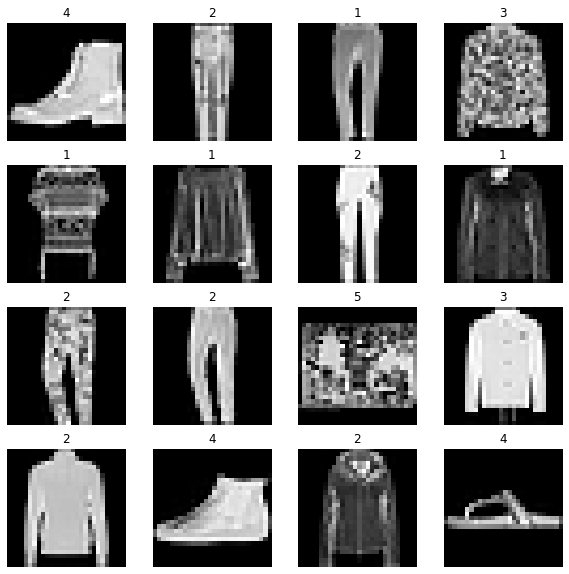

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize = (10,10))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = X[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(y[index].astype('int'))
        axe.set_axis_off()

The labels have been changed and it is not trivial to notice what the new labels actually represent.

'Number of figures in each class'

array([11989, 12019, 12011, 11992, 11989], dtype=int64)

Text(0, 0.5, 'Number of Elemenets in Each Class')

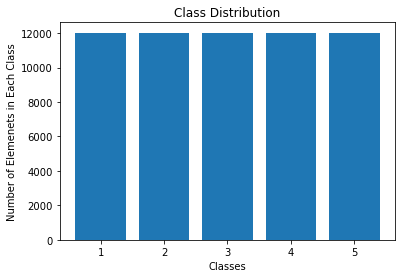

In [4]:
unique, counts = np.unique(y, return_counts=True)
display('Number of figures in each class', counts)

plt.figure()
plt.bar(unique, counts)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Elemenets in Each Class')

The distribution of classes is quite uniform, which means we do not need to over/under sample.

We perform a min-max normalization: 0 is black, 1 is white. We also reshape the training data into 60000x28x28x1, because Keras needs to know how many channels we will use (if it were RGB figures, there would be 3 channels). Finally, we do one hot encoding of the labels which creates 6 columns (because we have class 1-5) and we drop the first column which is only zeros.

In [5]:
from tensorflow.keras.utils import to_categorical

# reshape dataset to have a single channel
X = X.reshape(-1,28,28,1)
# normalize to range 0-1
X_norm = X.astype('float') / 255.0
# one hot encode target values
y = to_categorical(y)
y = y[:,1:6]

We will split the data into 80% training data, 10% validation data, and 10% test data. We select seed for all random process to be 0 for repeatability.

In [6]:
from sklearn.model_selection import train_test_split

seed = 0

X_train, X_aux, y_train, y_aux = train_test_split(X_norm, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.5, random_state=seed)

display('Shape of train data set', X_train.shape, 'Shape of the target train data set', y_train.shape)
display('Shape of validation data set', X_val.shape, 'Shape of the target validation data set', y_val.shape)
display('Shape of test data set', X_test.shape, 'Shape of the target test data set', y_test.shape)

'Shape of train data set'

(48000, 28, 28, 1)

'Shape of the target train data set'

(48000, 5)

'Shape of validation data set'

(6000, 28, 28, 1)

'Shape of the target validation data set'

(6000, 5)

'Shape of test data set'

(6000, 28, 28, 1)

'Shape of the target test data set'

(6000, 5)

# Creating a Convolutional Model

After a close inspection of the images, we didn't recognize any patterns in the figures. Therefore, our goal in designing our neural network was to have a shallow convolutional part, followed by a more deep dense part to try to understand the nonlinear function that describes this model. We chose this architecture because it was possible to train it on our computer in a reasonable amount of time and the accuracy is close to 85% which is similar to the result from the Kaggle competition provided in the assignment.

We will have a base model called model1 and we will see how different things affect the accuracy of the model.

Model 2 will be exactly the same as Model 1 with data augmentation.

Model 3 will use resnet.

References:
1. https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93/#2)-Visualizing-the-Dataset
2. https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

## Model 1: Base case

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model1 = Sequential()
# first block: convolutional + maxpooling
model1.add(Conv2D(32, (3, 3), activation='relu',padding = 'same',
                        input_shape=(28, 28, 1)))
model1.add(MaxPooling2D((2, 2), strides=2, padding="same"))
# second block: flatten + dense + dropout
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
# third block: dense
model1.add(Dense(32, activation='relu'))
# output layer
model1.add(Dense(5, activation='softmax'))
# we use Adam optimizer
opt1 = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model1.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                401472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [9]:
import time

startModel1 = time.time()
history1 = model1.fit(X_train, y_train, batch_size = 128, epochs=60, verbose=1, validation_data=(X_val, y_val))
endModel1 = time.time()

Epoch 1/60
375/375 [==============================] - 9s 23ms/step - loss: 1.5879 - accuracy: 0.3712 - val_loss: 1.3679 - val_accuracy: 0.4710
Epoch 2/60
375/375 [==============================] - 8s 20ms/step - loss: 1.2848 - accuracy: 0.4629 - val_loss: 1.0171 - val_accuracy: 0.5940
Epoch 3/60
375/375 [==============================] - 8s 20ms/step - loss: 1.0322 - accuracy: 0.5625 - val_loss: 0.9151 - val_accuracy: 0.6378
Epoch 4/60
375/375 [==============================] - 7s 20ms/step - loss: 0.9452 - accuracy: 0.6077 - val_loss: 0.8569 - val_accuracy: 0.6622
Epoch 5/60
375/375 [==============================] - 7s 20ms/step - loss: 0.8894 - accuracy: 0.6380 - val_loss: 0.8081 - val_accuracy: 0.6805
Epoch 6/60
375/375 [==============================] - 8s 20ms/step - loss: 0.8455 - accuracy: 0.6619 - val_loss: 0.7778 - val_accuracy: 0.6855
Epoch 7/60
375/375 [==============================] - 8s 20ms/step - loss: 0.8197 - accuracy: 0.6783 - val_loss: 0.7458 - val_accuracy: 0.6962

Epoch 58/60
375/375 [==============================] - 8s 21ms/step - loss: 0.4791 - accuracy: 0.8160 - val_loss: 0.4239 - val_accuracy: 0.8408
Epoch 59/60
375/375 [==============================] - 8s 21ms/step - loss: 0.4767 - accuracy: 0.8175 - val_loss: 0.4244 - val_accuracy: 0.8390
Epoch 60/60
375/375 [==============================] - 8s 21ms/step - loss: 0.4731 - accuracy: 0.8177 - val_loss: 0.4180 - val_accuracy: 0.8442


In [10]:
elapsedTimeModel1 = endModel1 - startModel1

display('The elapsed time to train Model 1 [seconds]', elapsedTimeModel1)

'The elapsed time to train Model 1 [seconds]'

464.49294900894165

In [11]:
_, acc1 = model1.evaluate(X_test, y_test, verbose=0)
display(acc1 * 100.0)

83.73333215713501

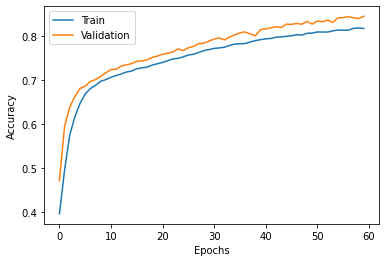

In [12]:
plt.figure()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

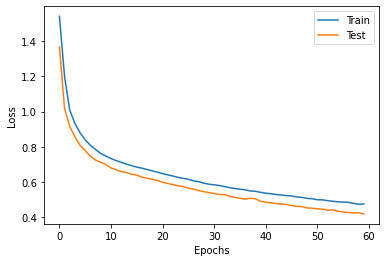

In [13]:
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

We need to compare several aspects:

1. Learning rate: we can tell by the noise in the loss and accuracy plots that the learning rate we chose is a little high because we see noise. It is not enough noise that forces us to decrease the learning rate.
2. By comparing the accuracy of the model on the training, validation and test sets we get 82.92%, 85.20%, and 84.56%, respectively. This indicates that we are not overfitting or underfitting. We will do some deeper analysis next.
3. If we notice both the loss and accuracy plots, the validation accuracy is still improving, so we could take a few epochs more, for probably a few percentage more.

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

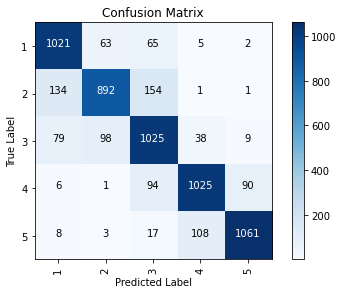

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred_model1 = model1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes_model1 = np.argmax(Y_pred_model1, axis=1) 
# Convert validation observations to one hot vectors
Y_true_model1 = np.argmax(y_test, axis=1) 
# compute the confusion matrix
confusion_mtx_model1 = confusion_matrix(Y_true_model1, Y_pred_classes_model1) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_model1, 
            classes = ['1','2','3','4','5'])

We notice that most mistakes are done between classes $i$ and $i+1$, with $i = 1, 2, 3, 4$. Note that almost no mistakes occur between class 1 and 4,5 or class 2 and 4,5 or class 3 and class 5. This is very interesting because it probably has something to do with what the new labels are about.

## Model 2: Base case with Data Augmentation

The model is exactly the same as Model 1, but we will analyze the effect of data augmentation.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model2 = Sequential()
# first block: convolutional + maxpooling
model2.add(Conv2D(32, (3, 3), activation='relu',padding = 'same',
                        input_shape=(28, 28, 1)))
model2.add(MaxPooling2D((2, 2), strides=2, padding="same"))
# second block: flatten + dense + dropout
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
# third block: dense
model2.add(Dense(32, activation='relu'))
# output layer
model2.add(Dense(5, activation='softmax'))
# we use Adam optimizer
opt2 = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                401472    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

The data augmentation will be done by selecting figures and randomly rotating them up to 10 degrees, zooming a little, shifting the images horizontally and vertically, doing horizontal flips (note that we will not do vertical flips because all figures have a particular orientation, i.e., we do not get upside down shirts).

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)

batch_size = 32
img_iter_model2 = datagen.flow(X_train, y_train, batch_size=batch_size)

datagen.fit(X_train)

In [18]:
import time

startModel2 = time.time()
history2 = model2.fit(img_iter_model2,
          epochs=60,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val))
endModel2 = time.time()

Epoch 1/60
1500/1500 [==============================] - 15s 10ms/step - loss: 1.5132 - accuracy: 0.3573 - val_loss: 1.0106 - val_accuracy: 0.5760
Epoch 2/60
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0587 - accuracy: 0.5458 - val_loss: 0.8931 - val_accuracy: 0.6293
Epoch 3/60
1500/1500 [==============================] - 15s 10ms/step - loss: 0.9699 - accuracy: 0.5887 - val_loss: 0.8442 - val_accuracy: 0.6432
Epoch 4/60
1500/1500 [==============================] - 15s 10ms/step - loss: 0.9237 - accuracy: 0.6075 - val_loss: 0.8048 - val_accuracy: 0.6640
Epoch 5/60
1500/1500 [==============================] - 16s 10ms/step - loss: 0.9065 - accuracy: 0.6188 - val_loss: 0.7800 - val_accuracy: 0.6683
Epoch 6/60
1500/1500 [==============================] - 15s 10ms/step - loss: 0.8887 - accuracy: 0.6298 - val_loss: 0.7652 - val_accuracy: 0.6820
Epoch 7/60
1500/1500 [==============================] - 15s 10ms/step - loss: 0.8736 - accuracy: 0.6382 - val_loss: 0.7518 -

1500/1500 [==============================] - 17s 11ms/step - loss: 0.6437 - accuracy: 0.7375 - val_loss: 0.4858 - val_accuracy: 0.8055
Epoch 57/60
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6475 - accuracy: 0.7367 - val_loss: 0.4825 - val_accuracy: 0.8040
Epoch 58/60
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6437 - accuracy: 0.7371 - val_loss: 0.4863 - val_accuracy: 0.8062
Epoch 59/60
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6402 - accuracy: 0.7401 - val_loss: 0.4856 - val_accuracy: 0.8050
Epoch 60/60
1500/1500 [==============================] - 16s 11ms/step - loss: 0.6406 - accuracy: 0.7381 - val_loss: 0.4799 - val_accuracy: 0.8105


In [19]:
elapsedTimeModel2 = endModel2 - startModel2

display('The elapsed time to train Model 2 [seconds]', elapsedTimeModel2)

'The elapsed time to train Model 2 [seconds]'

962.7435338497162

In [20]:
_, acc2 = model2.evaluate(X_test, y_test, verbose=0)
display(acc2 * 100.0)

80.23333549499512

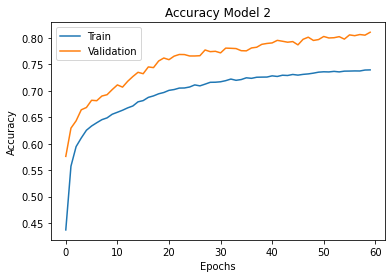

In [21]:
plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

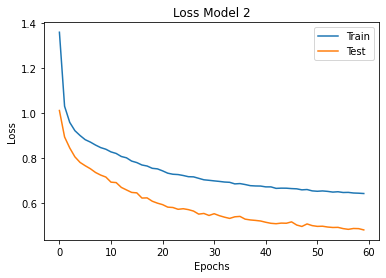

In [22]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

When we do data augmentation we notice right away that the learning rate is faster than the original case (this can be seen in the rate of change of the slope in both the accuracy and loss plots). We also notice that the accuracy on the train, validation, test sets are now 74, 81, 80, which indicates that the data augmentation actually lowered the accuracy score on the test set. This could be because of several reasons:

1. The depth of our network is not deep enough (i.e., we are trying to capture a very non-linear function without the correct amount of nodes.
2. The distortion we did to our figures during training make them not representative of our original problem (i.e., we added too much noise/distortion to the images).

Let us now analyze what happens to the confusion matrix.

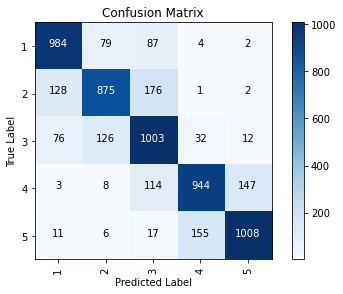

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred_model2 = model2.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes_model2 = np.argmax(Y_pred_model2, axis=1) 
# Convert validation observations to one hot vectors
Y_true_model2 = np.argmax(y_test, axis=1) 
# compute the confusion matrix
confusion_mtx_model2 = confusion_matrix(Y_true_model2, Y_pred_classes_model2)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_model2, 
            classes = ['1','2','3','4','5'])

By doing data augmentation we notice that the amount of mistakes between classes $i$ and $i+1$ increases slightly. It is not certain that data augmentation helps in this case, because we do not have prior information on what the new labels are. We may be introducing a new bias or increasing the variance of our training data set by mistake.

## Model 3: Adding ResNet

References:
1. https://www.kaggle.com/girishgupta/fashion-mnist-using-resnet

In [54]:
from tensorflow import keras
from tensorflow.keras.layers import Input, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation

input_size = (28, 28, 1)
num_filters = 64
use_max_pool = False
num_blocks = 2
num_sub_blocks = 2
num_classes = 5

#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
xx = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
xx = BatchNormalization()(xx)
xx = Activation('relu')(xx)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    xx = MaxPooling2D(pool_size=3, padding='same', strides=2)(xx)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        yy = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(xx)
        yy = BatchNormalization()(yy)
        yy = Activation('relu')(yy)
        yy = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(yy)
        yy = BatchNormalization()(yy)
        if is_first_layer_but_not_first_block:
            xx = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(xx)
        #Adding back residual mapping
        xx = keras.layers.add([xx, yy])
        xx = Activation('relu')(xx)

    num_filters = 2 * num_filters

# Add classifier on top.
xy = AveragePooling2D()(xx)
yy = Flatten()(xx)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(yy)

# Instantiate and compile model.
model3 = keras.Model(inputs=inputs, outputs=outputs)
model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=['accuracy'])
model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 14, 14, 64)   3200        input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_139 (BatchN (None, 14, 14, 64)   256         conv2d_164[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 14, 14, 64)   0           batch_normalization_139[0][0]    
____________________________________________________________________________________________

In [55]:
import time

startModel3 = time.time()
history3 = model3.fit(X_train, y_train, batch_size = 128, epochs=5, verbose=1, validation_data=(X_val, y_val))
endModel3 = time.time()

Epoch 1/5
375/375 [==============================] - 125s 331ms/step - loss: 0.9404 - accuracy: 0.7164 - val_loss: 3.0559 - val_accuracy: 0.1963
Epoch 2/5
375/375 [==============================] - 130s 345ms/step - loss: 0.5046 - accuracy: 0.8762 - val_loss: 0.7313 - val_accuracy: 0.7915
Epoch 3/5
375/375 [==============================] - 132s 352ms/step - loss: 0.4282 - accuracy: 0.9105 - val_loss: 0.5983 - val_accuracy: 0.8378
Epoch 4/5
375/375 [==============================] - 134s 356ms/step - loss: 0.3811 - accuracy: 0.9290 - val_loss: 0.5766 - val_accuracy: 0.8417
Epoch 5/5
375/375 [==============================] - 137s 366ms/step - loss: 0.3507 - accuracy: 0.9419 - val_loss: 0.5769 - val_accuracy: 0.8483


In [56]:
elapsedTimeModel3 = endModel3 - startModel3

display('The elapsed time to train Model 3 [seconds]', elapsedTimeModel3)

'The elapsed time to train Model 3 [seconds]'

657.4224174022675

In [57]:
_, acc3 = model3.evaluate(X_test, y_test, verbose=0)
display(acc3 * 100.0)

84.23333168029785

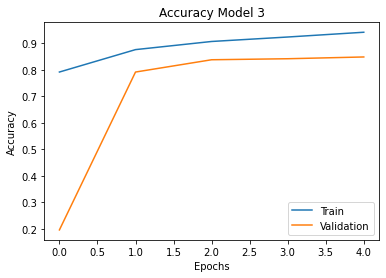

In [58]:
plt.figure()
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

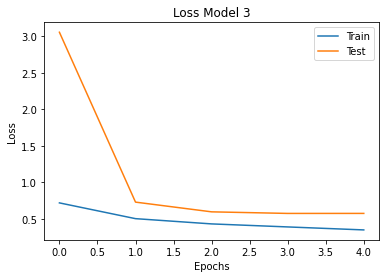

In [59]:
plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

When we do data augmentation we notice right away that the learning rate is faster than the original case (this can be seen in the rate of change of the slope in both the accuracy and loss plots). We also notice that the accuracy on the train, validation, test sets are now 74, 81, 80, which indicates that the data augmentation actually lowered the accuracy score on the test set. This could be because of several reasons:

1. The depth of our network is not deep enough (i.e., we are trying to capture a very non-linear function without the correct amount of nodes.
2. The distortion we did to our figures during training make them not representative of our original problem (i.e., we added too much noise/distortion to the images).

Let us now analyze what happens to the confusion matrix.

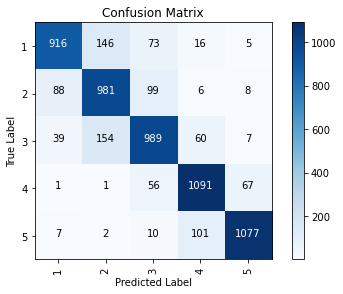

In [61]:
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred_model3 = model3.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes_model3 = np.argmax(Y_pred_model3, axis=1) 
# Convert validation observations to one hot vectors
Y_true_model3 = np.argmax(y_test, axis=1)
# compute the confusion matrix
confusion_mtx_model3 = confusion_matrix(Y_true_model3, Y_pred_classes_model3)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_model3, 
            classes = ['1','2','3','4','5'])



# Kaggle

In [63]:
dataK = np.load('fashion_mnist_dataset_kaggle_test.npy', allow_pickle=True).item()
idK = dataK['id']
XK = dataK['features']
XK = XK.reshape(-1,28,28,1)
XK = XK / 255.0

Y_pred = model3.predict(XK)
yK = np.argmax(Y_pred, axis=1)

import pandas as pd

kaggle_submission = pd.concat([pd.Series(idK, name='id'), pd.Series(yK, name='target')], axis=1)
kaggle_submission.to_csv(r'FashionMNISTKaggleRESNET.csv', index=False)